<a href="https://colab.research.google.com/github/papagorgio23/Python101/blob/master/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, accuracy_score

# Do not show warnings
import warnings
warnings.filterwarnings("ignore")

#Read the csv files and save them in dataframes
df_original=pd.read_csv('df_original.csv',low_memory=False)
df_new=pd.read_csv('df_new.csv',low_memory=False)

In [ ]:
# Create feature dataframe and response variable series for both dataframes
X1 = df_original.drop('charged_off',axis=1) # Feature dataframe 1
X2 = df_new.drop('charged_off',axis=1) # Feature dataframe 2
y = df_new.loc[:,'charged_off'] #Response variable is the same in both dataframes

In [ ]:
# Convert categorical features to dummy variables
X1_dummy = pd.get_dummies(X1)
X2_dummy = pd.get_dummies(X2)

# Drop one level from each categorical feature. A level is picked which has middle charged-off ratio across all levels.
# For instance, among loan grades, as the grades go from A to F, the charge-off ratio goes higher.
# In other words, grade D has the middle charged-off ratio and is removed. is selected (check the bar plot of grade in EDA1)
# If there is only two levels for a feature, the level with lower ratio is removed.

dummy_drop_list =['term_ 36 months','grade_D','home_ownership_OTHER','verification_status_Source Verified','purpose_other',
              'addr_state_AK','application_type_Individual','disbursement_method_Cash']

# Remove features in dummy_drop_list from the two dataframes
X1_dummy.drop(dummy_drop_list,axis=1,inplace=True)
X2_dummy.drop(dummy_drop_list,axis=1,inplace=True)

In [ ]:
# Split data into train and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_dummy, y, test_size=0.25,random_state=21, stratify=y)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_dummy, y, test_size=0.25,random_state=21, stratify=y)

In [ ]:
# 3 stratified folds are defined to be used as cross-validation splitting strategy. Since the training set is quite large 
# 3-fold is used instead of typical 5-fold strategy to speed up the cross validation processes.
kfolds = StratifiedKFold(n_splits=3,random_state=21) 

# Define standard scaler
scaler = StandardScaler()

In [ ]:
# Show the ratio of paid-off (0) and charged-off (1) loans in the response variable
y.value_counts(normalize=True)

0    0.798853
1    0.201147
Name: charged_off, dtype: float64

#### The machine learning process starts with logistic regression because of its simplicity. Scikit learn recommends to use stochastic gradient descent (SGD) for large scale data. The downside of SGD is it requires tuning several parameters to provide good results. Therefore, it is decided to use logistic regression but with ‘sag’ solver which is stochastic average gradient descent. The data set must be scaled before using the ‘sag’ solver. Also, class_weight parameter of the classifier is set to 'balanced' to address imbalance dataset. The model is built by deploying a pipeline of scaler and classifier. The model showed slightly better results on both accuracy and recall scores with X2_train set than X1_train.

In [ ]:
# Classifier with weighted balance
clf = LogisticRegression(class_weight='balanced',solver='sag',random_state=21)

# define the pipeline
pipeline = make_pipeline(scaler,clf)

# Run cross-validation with accuracy and recall scroing
scores = cross_validate(pipeline,X2_train,y2_train,cv=kfolds,scoring=['accuracy','recall'])

In [ ]:
# Print the average of results
print('The average of 3-fold cross-validation accuracy scores for the logistic regression is %.3f '
        %np.mean(scores['test_accuracy']))
print('The average of 3-fold cross-validation recall scores for the logistic regression is %.3f '
        %np.mean(scores['test_recall']))

The average of 3-fold cross-validation accuracy scores for the logistic regression is 0.657 
The average of 3-fold cross-validation recall scores for the logistic regression is 0.679 


In [ ]:
# Tune parameter C

# Define LogisticRegressionCV with recall scoring. Recall is chosen because it is more important 
# to predict charged-off loans than the paid-off ones.
clf=LogisticRegressionCV(Cs=np.logspace(-2,2,5),class_weight='balanced',solver='sag',cv=kfolds,scoring='recall',random_state=21)

# define the pipeline
pipeline = make_pipeline(scaler,clf)

# Fit the pipeline to the training set
pipeline.fit(X2_train,y2_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregressioncv', LogisticRegressionCV(Cs=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
           class_weight='balanced',
           cv=StratifiedKFold(n_splits=3, random_state=21, shuffle=False),
      ...    random_state=21, refit=True, scoring='recall', solver='sag',
           tol=0.0001, verbose=0))])

In [ ]:
# Access to LogisticRegressionCV
regcv = pipeline.steps[1][1]

# Print the best C
print('Best C is ',regcv.C_)

# Print the average of score for each C value
print('The average of the three scores for each C value:\n',regcv.scores_[1].mean(axis=0))

Best C is  [0.1]
The average of the three scores for each C value:
 [0.67862657 0.67873123 0.67869983 0.67869983 0.67870507]


#### Although the best C value is 0.1, the average of three scores across the five C values are within less than 0.001 of each other. Therefore, the default value C=1 will be kept. 

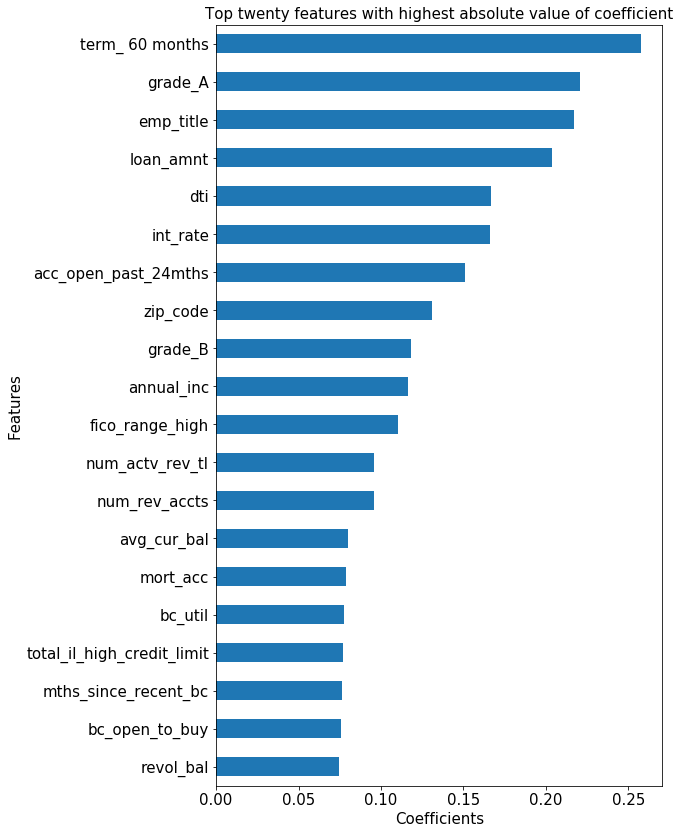

In [ ]:
# Classifier with weighted balance
clf = LogisticRegression(class_weight='balanced',solver='sag',random_state=21)

# define the pipeline
pipeline = make_pipeline(scaler,clf)

# Fit the pipeline to the training set
pipeline.fit(X2_train,y2_train)

# Create dataframe of feature coefficients
feature_df = pd.DataFrame(np.transpose(np.abs(pipeline.steps[1][1].coef_)),columns=['coefficient'],index=X2_train.columns)\
.sort_values(by='coefficient')

# Plot top twenty features with highest absolute value of coefficients. Since the features are scaled,
# the absolute coefficient value represents feature importance.
feature_df.iloc[-20:].plot.barh(figsize=(8,14),legend=False)
plt.xlabel('Coefficients',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.title('Top twenty features with highest absolute value of coefficient',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.show()

In [ ]:
# In order to analyze the important numerical features, they are discretized and the charged-off ratio across each bin
# is claculated and plottd
def binning(feature,bins):
    """This function discretize the specified feature of df based on the bins parameter and generates
    a bar plot which shows the charged-off ratio across the bins"""
    df_copy = df_original.loc[:,[feature,'charged_off']]
    df_copy[feature+'_bins']=pd.cut(df_copy[feature],bins=bins).astype('str').str.replace('(','').str.replace(']','').str.replace(', ','_')
    listt=['{}_{}'.format(float(bins[m]),float(bins[m+1])) for m in range(len(bins)-1)]
    group=df_copy.groupby(feature+'_bins')['charged_off'].mean()
    group.loc[listt].plot.barh(figsize=(10,8))
    plt.ylabel(feature+'_bins',fontsize=15)
    plt.xticks(rotation='horizontal',fontsize=15)
    plt.xlabel('charged_off ratio',fontsize=15)
    plt.title('charged_off ratio across all levels of {}'.format(feature+'_bins'),fontsize=15)
    plt.show()

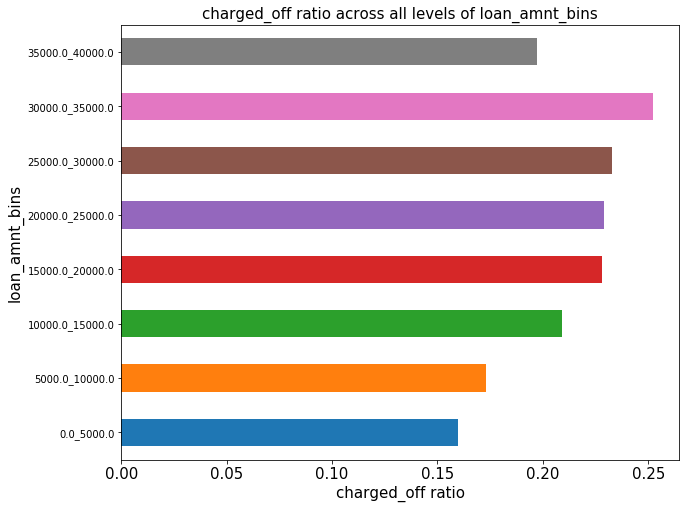

In [ ]:
# Apply binning function on loan_amnt
bins=np.arange(0.0,40001.0,5000.0)
binning('loan_amnt',bins)

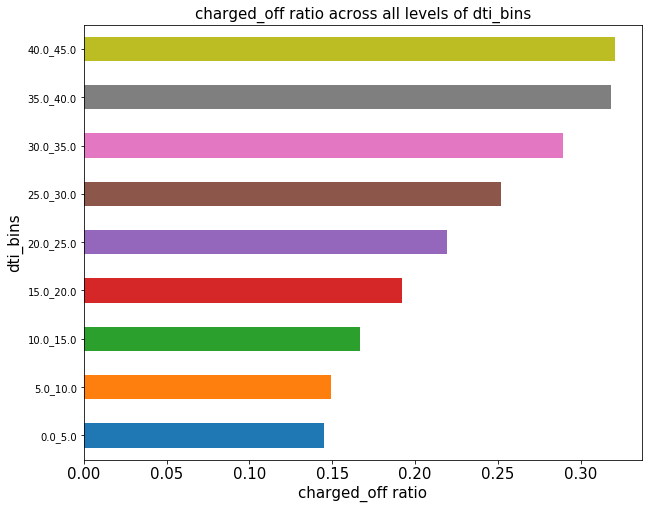

In [ ]:
# Apply binning function on dti
bins=np.arange(0,46.0,5.0)
binning('dti',bins)

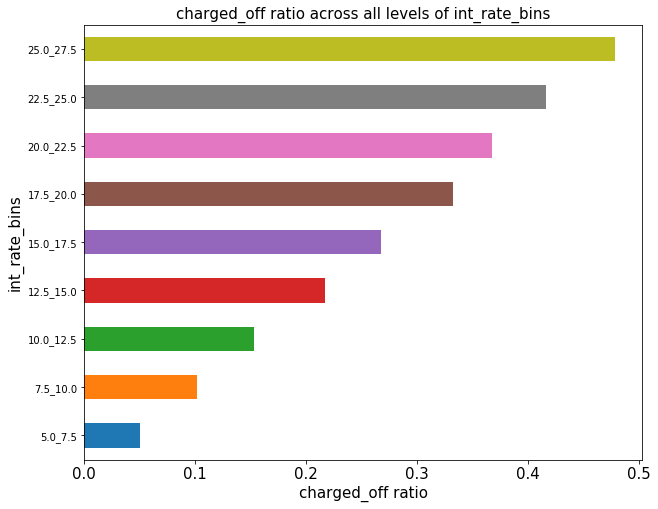

In [ ]:
# Apply binning function on int_rate
bins=np.arange(5,30,2.5)
binning('int_rate',bins)

In [ ]:
# 'emp_title','zip_code' were originally categorical and were transformed to numerical. They both
# have high coefficients. It is worth checking the performnace of the logistic regression classifier after removing them.
X2_train_new = X2_train.drop(['emp_title','zip_code'],axis=1)

# Run cross-validation score
scores = cross_val_score(pipeline,X2_train_new,y2_train,cv=kfolds,scoring='recall')

# Print the average of results
print('The average of 3-fold cross-validation recall scores for the logistic regression classifier after \
removing employment title \nand zip code is %.3f'%np.mean(scores))

The average of 3-fold cross-validation recall scores for the logistic regression classifier after removing employment title 
and zip code is 0.674


In [ ]:
### Removing 'emp_title','zip_code' did not improve the recall score. Therefore, they will be kept.

In [ ]:
# Print number of features in X2
print('X2 has {} features'.format(len(X2_train.columns)))

X2 has 128 features


In [ ]:
# Add interaction terms. There are 128 features after transforming categorical features. Interaction between all of them
# make the model too complex. Fifty of the features are dummy variables of states. Since these variables do not have
# large coefficients, they are removed before adding interaction terms.

new_feature_list = [feature for feature in X2_train.columns if 'addr_state' not in feature]
X2_train_new = X2_train.loc[:,new_feature_list]

# Define interaction terms
interaction = PolynomialFeatures(degree = 2,interaction_only=True)

# Define pipeline
pipeline = make_pipeline(interaction,scaler,clf)

# Run cross-validation 
scores = cross_val_score(pipeline,X2_train_new,y2_train,cv=kfolds,scoring='recall')

#print results
print('The average 3-fold cross-validation recall scores for the logistic regression with interaction terms is %.3f '
      %np.mean(scores))

#### The average cross validation recall score improved only by 0.002. Therefore, the interaction terms will not be added to the logistic regression model.

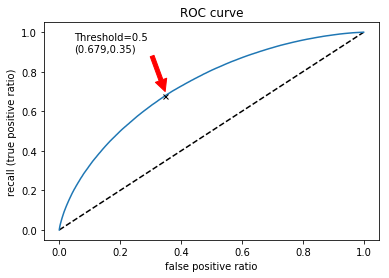

In [ ]:
# Plot ROC curve for the training data set

# Classifier
clf = LogisticRegression(class_weight='balanced',solver='sag',random_state=21)

# Pipeline
pipeline = make_pipeline(scaler,clf)

# Fit pipeline to training set
pipeline.fit(X2_train,y2_train)

# Compute probability estimates
y2_predict_proba = pipeline.predict_proba(X2_train)

# Compute true positive ratio (recall) and false positive ratio
fpr, tpr, thresholds = roc_curve(y2_train,y2_predict_proba[:,1])

# Find the false positive ratio corresponding to recall 0.679
a = np.argwhere(np.round(tpr,3)==0.679)[0]
b = np.float(fpr[a])

# Plot ROC curve and the point corresponding to threshold  = 0.5
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.plot(b,0.679,marker='x',markersize=5,color='black')
plt.annotate('Threshold=0.5 \n(0.679,%.2f)'%b,(b,0.7),(0.05,0.9),arrowprops={'color':'red'})
plt.xlabel('false positive ratio')
plt.ylabel('recall (true positive ratio)')
plt.title('ROC curve')
plt.show()

#### Raising the threshold to increase recall in the expense of increasing false positive ratio is a business decision, but in my opinion, false positive ratio of 0.35 is already too high because it means more than one-third of eligible applicants are labeled as charged-off. Therefore, the threshold will not be raised.

#### Conclusion: The final logistic regression classifier has the following parameters: class_weight='balanced', solver='sag', and C=1. The average 3-fold cross-validation accuracy and recall scores of the logistic regression are 0.657 and 0.679, respectively.

#### It was necessary to make several data transformation on numerical features because of the special distribution of each feature. Tree-based models are robust to data distributions. Therefore, an XGBoost classifier is developed in the next section.

# XGBoost Classifier

In [ ]:
# Define classifier 
clf = XGBClassifier(scale_pos_weight=4,random_state=21)

# Run cross validation
scores = cross_validate(clf,X1_train,y1_train,cv=kfolds,scoring=['accuracy','recall'])

In [ ]:
# Print the average of results
print('The average of 3-fold cross-validation accuracy scores for the XGBoost classifier is %.3f '
      %np.mean(scores['test_accuracy']))
print('The average of 3-fold cross-validation recall scores for the XGBoost classifier is %.3f '
        %np.mean(scores['test_recall']))

The average of 3-fold cross-validation accuracy scores for the XGBoost classifier is 0.659 
The average of 3-fold cross-validation recall scores for the XGBoost classifier is 0.684 


#### Both accuracy and recall scores slightly improved compared to the logistic regression classifier.

#### In order to improve the recall score, five parameters are tuned based on the mentioned values: n_estimators: {20,50,100}, learning_rate: {0.05,0.1,0.2}, max_depth: {3,4,5}, subsample:{0.6,0.8,1}, and colsample_bytree:{0.4,0.7,1}. Since the dataset is quite large, the parameters are tuned one by one. The process starts with number of estimators and assign the rest of parameters to the middle value of their corresponding set.

In [ ]:
# Define a function which receives classifier, parameter values, cross-validation folds, and features and response 
# variable of training set as inputs, tune hyper parameters and prints the best score and best parameter value

def tuning(classifier,param_set,cv_folds=kfolds,train_feature=X1_train,train_response=y1_train):
    """This function tunes hyper parameters of the classifier. The hyper parameters are defined by parame_set.
    The tuning is performed by GridSearchCV with folds defined by cv_folds."""
    model = GridSearchCV(classifier,param_grid=param_set,cv=cv_folds,scoring='recall') 
    model.fit(train_feature,train_response)
    print('The best score in parameter tuning is: %.3f'%model.best_score_)
    print('The best parameter value is: ',model.best_params_)    
    return model

In [ ]:
# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,learning_rate=0.1,max_depth=4,subsample=0.8,colsample_bytree=0.7)

# Define parameter
parameter = {'n_estimators':[20,50,100]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.687
The best parameter value is:  {'n_estimators': 100}


In [ ]:
# Print the mean of test scores for each value of n_estimators 
cv.cv_results_['mean_test_score']

array([0.68673298, 0.68503215, 0.68701558])

In [ ]:
# Score goes up quite slowly.Therefore, n_estimators beyond 100 will not be tested. 
# Tune learning_rate

# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,max_depth=4,subsample=0.8,colsample_bytree=0.7)

# Define parameter
parameter = {'learning_rate':[0.05,0.1,0.2]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.688
The best parameter value is:  {'learning_rate': 0.2}


In [ ]:
# Print the mean of test scores for each value of learning_rate 
cv.cv_results_['mean_test_score']

array([0.68663879, 0.68701558, 0.68807795])

In [ ]:
# Score goes up very slowly. Therefore, learning_rate beyond 0.2 will not be tested. 
# Tune max_depth.

# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,learning_rate=0.2,subsample=0.8,colsample_bytree=0.7)

# Define parameter
parameter = {'max_depth':[3,4,5]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.688
The best parameter value is:  {'max_depth': 4}


In [ ]:
# Print the mean of test scores for each value of max_depth
cv.cv_results_['mean_test_score']

array([0.68701559, 0.68807795, 0.68673822])

In [ ]:
# max_depth = 4
#Tune subsample

# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,learning_rate=0.2,max_depth=4,colsample_bytree=0.7)

# Define parameter
parameter = {'subsample':[0.6,0.8,1]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.688
The best parameter value is:  {'subsample': 0.6}


In [ ]:
# Print the mean of test scores for each value of subsample 
cv.cv_results_['mean_test_score']

array([0.68828205, 0.68807795, 0.68772731])

In [ ]:
# Score goes up very slowly as the subsample goes down. Therefore, subsamples below 0.6 will not be tested. 
# Tune colsample_bytree

# Define classifier
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,learning_rate=0.2,max_depth=4,subsample=0.6)

# Define parameter
parameter = {'colsample_bytree':[0.4,0.7,1]}

# Run tuning on the classifier
cv = tuning(clf,parameter)

The best score in parameter tuning is: 0.688
The best parameter value is:  {'colsample_bytree': 0.7}


In [ ]:
# Print the mean of test scores for each value of colsample_bytree
cv.cv_results_['mean_test_score']

array([0.68619395, 0.68828205, 0.68772732])

In [ ]:
# Define the classifier with tuned parameters
clf = XGBClassifier(scale_pos_weight=4,random_state=21,n_estimators=100,learning_rate=0.2,max_depth=4,subsample=0.6
                    ,colsample_bytree=0.7)

# Fit the classifier to the training set
clf.fit(X1_train,y1_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=21, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
       seed=None, silent=True, subsample=0.6)

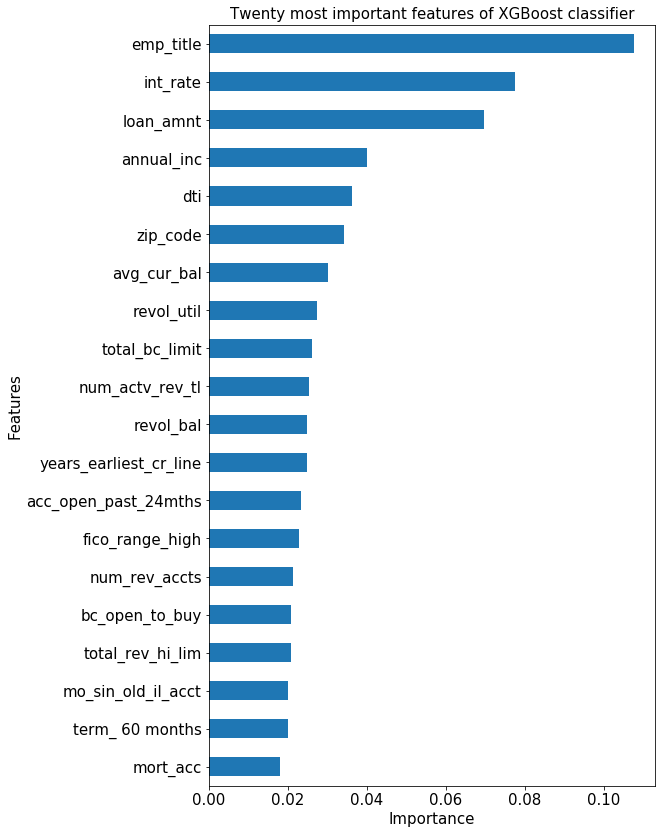

In [ ]:
# Plot the feature importance diagram of top 20 most important features.
features = pd.DataFrame(clf.feature_importances_, index = X1_train.columns,
                            columns=['importance']).sort_values('importance',ascending=True)

features.iloc[-20:].plot.barh(figsize=(8,14),legend = False)
plt.xlabel('Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.title ('Twenty most important features of XGBoost classifier',fontsize=15)
plt.show()

In [ ]:
# As the feature importance diagram is showing, emp_title and zip_code are first and forth most important features.
# Since the two features were originally categorical variables and were transformed to numerical ones, it is worth 
# checking if removing them improves the performance of the model

X1_train_new = X1_train.drop(['emp_title','zip_code'],axis=1)

# Run cross-validation score
scores = cross_val_score(clf,X1_train_new,y1_train,cv=kfolds,scoring='recall')

# Print the average of results
print('The average of 3-fold cross-validation recall scores for the XGBoost classifier after removing employment title \
and zip code \nis %.3f'%np.mean(scores))

The average of 3-fold cross-validation recall scores for the XGBoost classifier after removing employment title and zip code 
is 0.679


In [ ]:
# Removing 'emp_title','zip_code' did not improve the recall score. Therefore, they will be kept.

In [ ]:
# Now the model is simplified by keeping the important features and removing the rest

# Create a list of features with importance higher than 0
feature_keep = features.loc[features.importance>0].index

# Print the number of important features
print('The number of features with importance more than 0 is ',len(feature_keep))

The number of features with importance more than 0 is  81


In [ ]:
# Remove unimportant features
X1_train_new = X1_train.loc[:,feature_keep]

# Run cross-validate score to make sure performance of the model did not decrease
scores = cross_validate(clf,X1_train_new,y1_train,cv=kfolds,scoring=['recall','accuracy'])

# Print the results
print('The average of 3-fold cross-validation accuracy scores for the XGBoost classifier after removing unimportant features is %.3f '
        %np.mean(scores['test_accuracy']))
print('The average of 3-fold cross-validation recall scores for the XGBoost classifier after removing unimportant features is %.3f '
        %np.mean(scores['test_recall']))

The average of 3-fold cross-validation accuracy scores for the XGBoost classifier after removing unimportant features is 0.667 
The average of 3-fold cross-validation recall scores for the XGBoost classifier after removing unimportant features is 0.689 


### Final Model: both average 3-fold cross-validation accuracy and recall scores of the XGBoost classifier are only about 1.5% higher than the corresponding scores of the logistic regression model. Since the logistic regression model is simpler and more interpretable, it is selected as the final model.

### Find the accuracy and recall scores of the test set.

In [ ]:
# Classifier with weighted balance
clf = LogisticRegression(class_weight='balanced',solver='sag',random_state=21)

# define the pipeline
pipeline = make_pipeline(scaler,clf)

# Fit the pipeline on the train set
pipeline.fit(X2_train,y2_train)

# Predict the response variable of the test set
y2_predict = pipeline.predict(X2_test)

# Print recall and accuracy scores of the test set
print('The accuracy score of the test set is %.3f'%accuracy_score(y2_test,y2_predict))
print('The recall score of the test set is %.3f'%recall_score(y2_test,y2_predict))

The accuracy score of the test set is 0.658
The recall score of the test set is 0.679


### Recall score of the test set is the same as the average 3-fold cross-validation recall score of the training set. Accuracy score of the test set is 0.001 more than the average 3-fold cross-validation accuracy score of the training set.